In [1]:
from qlearning import QLearner
from grid_world import PickUpAndDeliver
import pandas as pd
import numpy as np

In [2]:
def reward(state):
    position, damage, pickup = state
    if damage == 5:
        return np.array([-25,-25])
    if position == 10 and pickup == True:
        return np.array([25, 25-(damage*-5)])
    else:
        return np.array([-1, 0])
    
def update_state(state, actor_pos):
    terminal = False
    _, damage, pickup = state
    damage_pos = [3,4,6,8,11,13,16,20,23]
    if actor_pos in damage_pos:
        damage += 1
    if actor_pos == 9:
        pickup = True
    if (actor_pos == 10 and pickup) or damage == 5:
        terminal = True
    return (actor_pos, damage, pickup), terminal
    
def env():
    height = 5
    width = 5
    inital_state = (10, 0, False)
    return PickUpAndDeliver(inital_state, reward, update_state, 10, height, width)

In [3]:
def qlearner(learning_rate=0.1, discount_factor=0.9, explore_rate = 0.1):
    learner = QLearner(['up', 'down', 'right', 'left'], learning_rate, discount_factor, explore_rate, objectives=2)
    episodes = list()
    for episode in range(1, 1000):
        totalValue = 0
        actions = list()
        world = env()
        learner.start_episode(world.current_state())

        end = False
        while end != True:
            action = learner.act(world.current_state())
            actions.append(action)
            value, end = world.act(action)
            totalValue += value[0]
            learner.reward(value, world.current_state())

        learner.end_episode()
        episodes.append((episode, totalValue, actions))
    return learner, episodes

def episodes_to_df(episodes, columns=['episode', 'total value', 'actions']) -> pd.DataFrame:
    return pd.DataFrame(episodes, columns=columns)

def print_actions(episodes):
    for episode, totalValue, actions in episodes:
        print("Episode: {}, total value: {}, actions: {}".format(episode, totalValue, actions))

In [4]:
q1, q1_episodes = qlearner()
q1_df = episodes_to_df(q1_episodes)

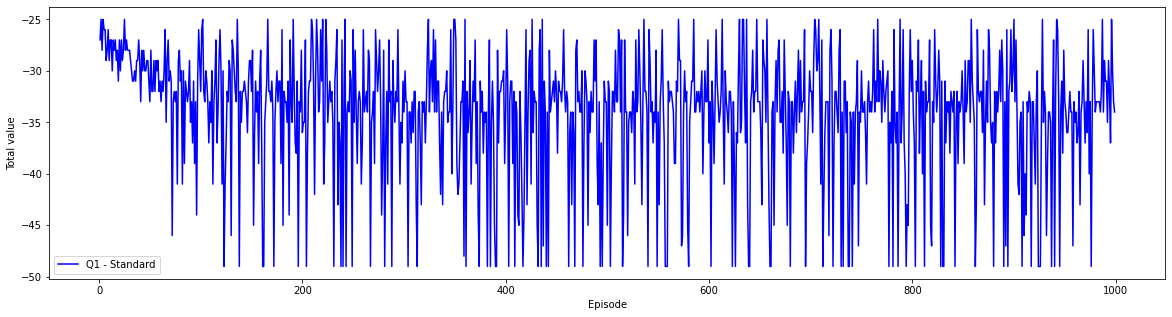

In [5]:
from matplotlib import pyplot
pyplot.figure(figsize=(20,5))
pyplot.plot(range(1, 1000), q1_df['total value'], 'b-')
pyplot.ylabel("Total value")
pyplot.xlabel("Episode")
pyplot.legend(['Q1 - Standard'])
pyplot.show()

In [6]:
q1_df

,episode,total value,actions
0,1,-27,"[up, up, up]"
1,2,-25,[down]
2,3,-28,"[right, up, up, up]"
3,4,-25,[left]
4,5,-26,"[up, down]"
...,...,...,...
994,995,-37,"[right, right, left, left, up, up, right, left..."
995,996,-25,[left]
996,997,-30,"[right, up, right, left, up, down]"
997,998,-33,"[up, right, right, right, up, left, left, righ..."
